### Scattering

I will show how to compute the scattering cross section of a lossy dielectric cylindrical rod in vaccuum using the [`gyptis`](https://gyptis.gitlab.io) package.

In [84]:
import numpy as np
import gyptis as gy
import matplotlib.pyplot as plt

In [85]:
wl = 500 # wavelength in nm
R = 300 # rod radius in nm
eps_rod = (4.2992-0.070425j)**2  # rod permittivity (Si)
eps_bg = 1 # background permittivity
pmesh = 10 # mesh parameter

First we will define the geometry

In [86]:
geom = gy.BoxPML(
    dim=2, # geometric dimension of the problem (2D)
    box_size=(5*wl, 5*wl), # size of the rectangular box
    pml_width=(wl, wl), # length of PMls
    Rcalc=0.9*3*wl/2, # the radius of a circle for computing cross sections
)

Add the the circular rod:

In [87]:
rod = geom.add_circle(0, 0, 0, R)
rod,*bg,  = geom.fragment(rod, geom.box)

In [88]:
geom.add_physical(bg, "box")
geom.add_physical(rod, "rod")

7

In [89]:
lmin = wl/pmesh

[geom.set_size(pml, lmin * 1) for pml in geom.pmls]
geom.set_size("box", lmin / eps_bg.real**0.5)
geom.set_size("rod",  lmin / eps_rod.real**0.5)
geom.build()

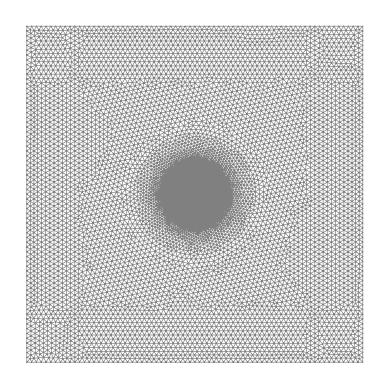

In [90]:
geom.plot_mesh(lw=0.5)
plt.axis("off")
plt.show()

We define a plane wave incident on the scatterer

In [91]:
pw = gy.PlaneWave(wavelength=wl, angle=0, dim=2, domain=geom.mesh, degree=2)

Visualize the plane wave

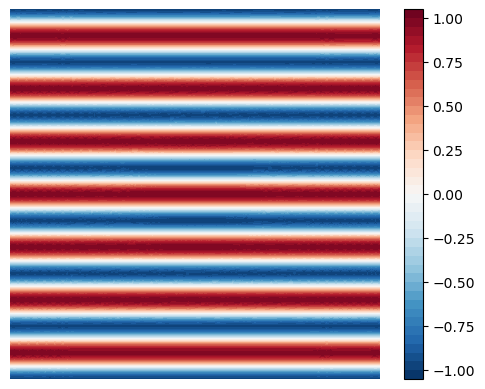

In [92]:
from gyptis.plot import plot
V = gy.dolfin.FunctionSpace(geom.mesh,"CG",2)
pw_proj = gy.utils.project_iterative(pw.expression.real,V)
plot(pw_proj,cmap="RdBu_r")
plt.axis("off")
plt.show()

Define the material properties (relative permittivity and permeability).

In [93]:
epsilon = dict(box=eps_bg, rod=eps_rod)
mu = dict(box=1, rod=1)

We are ready to build the simulation object, first for TE polarization (in plane electric field).

In [94]:
sTE = gy.Scattering(
    geom,
    epsilon,
    mu,
    pw,
    degree=2,
    polarization="TE",
)

Solve the problem.

In [95]:
uTE = sTE.solve()

Plot the magnetic field.

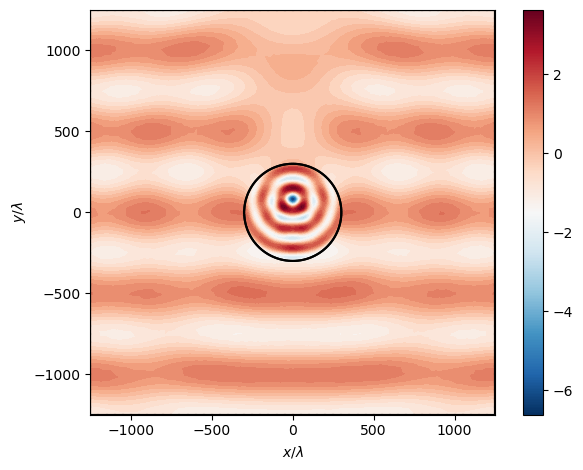

In [96]:
sTE.plot_field()
geom_lines = geom.plot_subdomains()
plt.xlabel(r"$x/\lambda$")
plt.ylabel(r"$y/\lambda$")
plt.tight_layout()

Compute the cross sections and check energy conservation (optical theorem).

In [104]:
csTE = sTE.get_cross_sections()
print(f"sigma_s = {csTE['scattering']:.1f}nm")
print(f"sigma_e = {csTE['extinction']:.1f}nm")
print(f"sigma_a = {csTE['absorption']:.1f}nm")
print(f"balance = {(csTE['scattering'] + csTE['absorption'])/csTE['extinction']:.5f}")
assert np.allclose(csTE["extinction"], csTE["scattering"] + csTE["absorption"], rtol=1e-3)

sigma_s = 732.5nm
sigma_e = 1153.4nm
sigma_a = 421.9nm
balance = 1.00091


We now switch to TM polarization (out of plane electric field).

In [98]:
sTM = gy.Scattering(
    geom,
    epsilon,
    mu,
    pw,
    degree=2,
    polarization="TM",
)

In [99]:
uTM = sTM.solve()

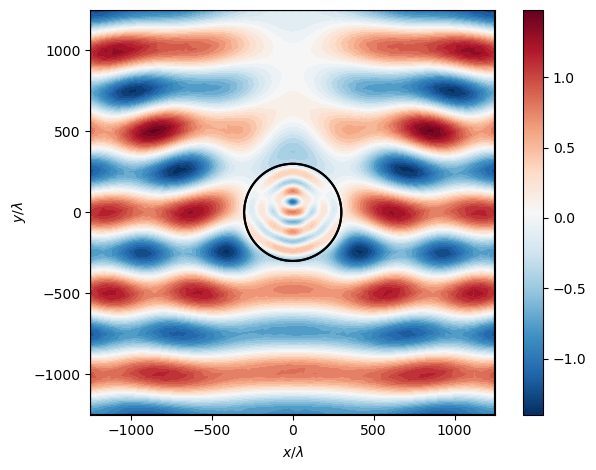

In [100]:
sTM.plot_field()
geom_lines = geom.plot_subdomains()
plt.xlabel(r"$x/\lambda$")
plt.ylabel(r"$y/\lambda$")
plt.tight_layout()

In [103]:
csTM = sTM.get_cross_sections()
print(f"sigma_s = {csTM['scattering']:.1f}nm")
print(f"sigma_e = {csTM['extinction']:.1f}nm")
print(f"sigma_a = {csTM['absorption']:.1f}nm")
print(f"balance = {(csTM['scattering'] + csTM['absorption'])/csTM['extinction']:.5f}")
assert np.allclose(csTM["extinction"], csTM["scattering"] + csTM["absorption"], rtol=1e-3)

sigma_s = 998.4nm
sigma_e = 1394.4nm
sigma_a = 397.1nm
balance = 1.00076
